In [1]:
## > LIBRARIES
import os
import re
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import math

os.chdir('C:/Users/cg08900/Documents/Pandora/Personale/kaggle/NCAA_2k19/prog/functions/')

from ncaa19 import *

sns.set()

## > DATA
path_datasets = 'C:/Users/cg08900/Documents/Pandora/Personale/kaggle/NCAA_2k19/datasets/'
path_elab = 'C:/Users/cg08900/Documents/Pandora/Personale/kaggle/NCAA_2k19/elaborazioni/'

df_rs_c_res = pd.read_csv(path_datasets + 'RegularSeasonCompactResults.csv')
df_rs_d_res = pd.read_csv(path_datasets + 'RegularSeasonDetailedResults.csv')
df_teams = pd.read_csv(path_datasets + 'Teams.csv')
df_seeds = pd.read_csv(path_datasets + 'NCAATourneySeeds.csv')
coaches = pd.read_csv(path_datasets + 'TeamCoaches.csv')
df_tourn = pd.read_csv(path_datasets + 'NCAATourneyCompactResults.csv')
mysub = pd.read_csv(path_datasets + 'SampleSubmissionStage1.csv')
massey = pd.read_csv(path_datasets + 'MasseyOrdinals/MasseyOrdinals.csv')

In [2]:
## > DATA CLEANING
# cleaning seeds
df_seeds_cl = df_seeds.loc[:, ['TeamID', 'Season', 'Seed']]
df_seeds_cl['seed_int'] = df_seeds_cl['Seed'].apply(lambda x: clean_seed(x))
df_seeds_cl['seed_region'] = df_seeds_cl['Seed'].apply(lambda x: extract_seed_region(x))
df_seeds_cl['top_seeded_teams'] = np.where(df_seeds_cl['Seed'].isnull(), 0, 1)
df_seeds_cl.drop(labels=['Seed'], inplace=True, axis=1) # This is the string label

# clean team information
df_teams_cl = df_teams.iloc[:,:2]

# create games dataframe WINNERS
df_games_w = prepare_stats_extended_winners(df_in=df_rs_d_res.copy(), 
                                            df_seed_in=df_seeds_cl.copy(), 
                                            df_teams_in=df_teams_cl.copy())

# create games dataframe LOSERS
df_games_l = prepare_stats_extended_losers(df_in=df_rs_d_res.copy(), 
                                           df_seed_in=df_seeds_cl.copy(), 
                                           df_teams_in=df_teams_cl.copy())

# merge both winners and losers dataset
df_games_t = pd.concat([df_games_w,df_games_l], sort=True)

# aggregating by teams and seasons
df_agg_stats = df_games_t.\
                          groupby([df_games_t['Season'], 
                                   df_games_t['TeamID'],
                                   df_games_t['TeamName'],
                                   df_games_t['seed_int'],
                                   df_games_t['seed_region']], 
                                  as_index=False).\
                          apply(aggr_stats).\
                          reset_index()


df_agg_stats['w_pct'] = df_agg_stats['W'] / df_agg_stats['G']
df_agg_stats['w_pct_last30D'] = df_agg_stats['W_last30D'] / df_agg_stats['G_last30D']
df_agg_stats['w_pct_vs_topseeds'] = df_agg_stats['W_vs_topseeds'] / df_agg_stats['G_vs_topseeds']

# create ranking
regressors = ['poss_m', 'opp_poss_m',
              'ass_ratio', 'tov_ratio', 
              'reb_rate', 'opp_true_fg_pct', 
              'off_rating_m','def_rating_m', 
              'net_rating_m', 'pace_m', 
              'off_rating_m_last30D',
              'def_rating_m_last30D', 
              'net_rating_m_last30D',
              'off_rating_m_vs_topseeds', 
              'def_rating_m_vs_topseeds',
              'net_rating_m_vs_topseeds', 
              'seed_int',
              'w_pct', 'w_pct_last30D',
              'w_pct_vs_topseeds']

for index in regressors:
    df_agg_stats[index] = df_agg_stats.groupby('Season')[index].rank(ascending=False)
    df_agg_stats[index] = df_agg_stats[index]
    df_agg_stats[index] = 100 - 4*np.log(df_agg_stats[index]) - df_agg_stats[index]/22

# cleaning coach stats
coaches_stats = prepare_stats_coach(df_coach_in = coaches, 
                                    df_tourn_in = df_tourn, 
                                    df_stats_agg_in = df_agg_stats)

# cleaning massey ordinals
massey_exploded = prepare_massey_ord(massey)

y_ok = [2003, 2004, 2005, 2006,
        2007, 2008, 2009, 2010,
        2011, 2012, 2013, 2014,
        2015, 2016, 2017, 2018]

# cleaning tournament data
df_tourn_cl = prepare_tournament_datasets(df_tourn_in=df_tourn.copy(), 
                                          df_agg_stats_in=df_agg_stats.copy(), 
                                          df_coach_in=coaches_stats, 
                                          df_massey_in=massey_exploded,
                                          list_feat_in = regressors) 
df_tourn_cl_gr = df_tourn_cl[(df_tourn_cl['Season'].isin(y_ok))].reindex()

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

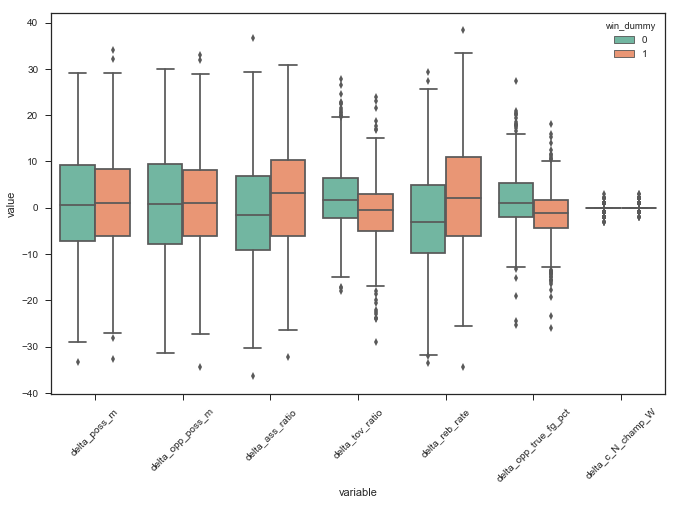

In [3]:
## > DATA VIZ TOURNEY 1
sns.set(style="ticks", color_codes=True)

df_tourn_cl_gr_1 = df_tourn_cl_gr.loc[:,['win_dummy',
                                         'delta_poss_m', 'delta_opp_poss_m',
                                         'delta_ass_ratio', 'delta_tov_ratio', 
                                         'delta_reb_rate',
                                         'delta_opp_true_fg_pct', 'delta_c_N_champ_W']]

fig, ax = plt.subplots(figsize=(11, 7))
sns.boxplot(x="variable", y="value", hue = 'win_dummy', ax=ax, 
            data=pd.melt(df_tourn_cl_gr_1, id_vars='win_dummy'), palette="Set2")
plt.xticks(rotation=45)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

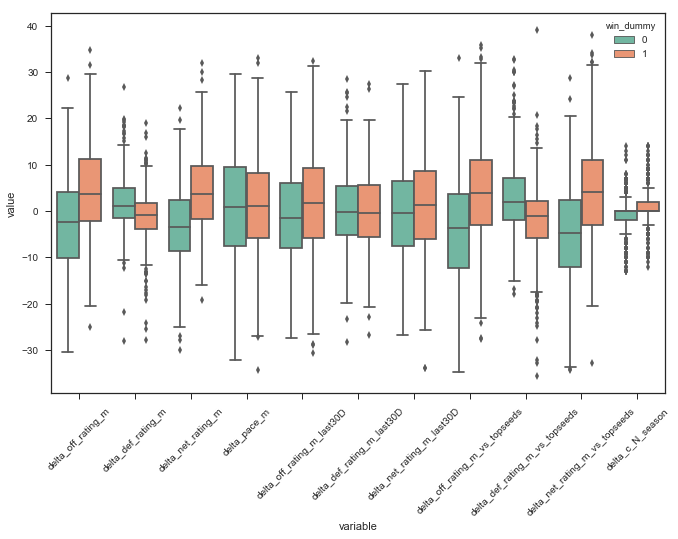

In [4]:
## > DATA VIZ TOURNEY 2
sns.set(style="ticks", color_codes=True)

df_tourn_cl_gr_2 = df_tourn_cl_gr.loc[:,['win_dummy',
                                         'delta_off_rating_m', 'delta_def_rating_m',
                                         'delta_net_rating_m', 'delta_pace_m', 'delta_off_rating_m_last30D',
                                         'delta_def_rating_m_last30D', 'delta_net_rating_m_last30D',
                                         'delta_off_rating_m_vs_topseeds', 'delta_def_rating_m_vs_topseeds',
                                         'delta_net_rating_m_vs_topseeds', 'delta_c_N_season']]

fig, ax = plt.subplots(figsize=(11, 7))
sns.boxplot(x="variable", y="value", hue = 'win_dummy', ax=ax, 
            data=pd.melt(df_tourn_cl_gr_2, id_vars='win_dummy'), palette="Set2")
plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

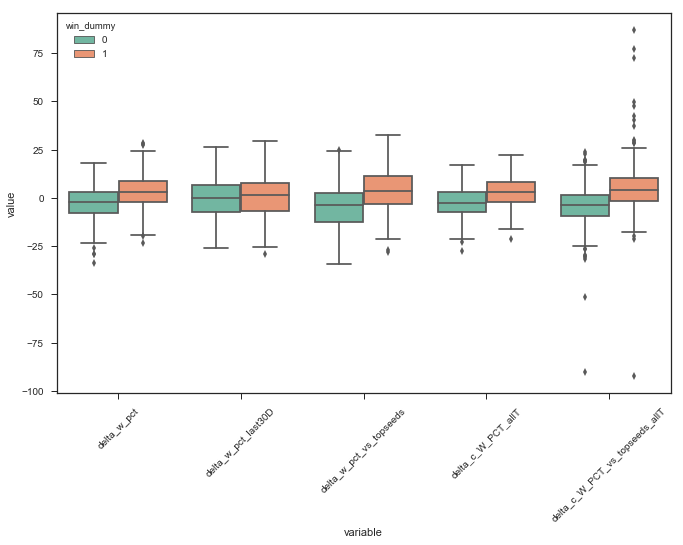

In [5]:
## > DATA VIZ TOURNEY 3
sns.set(style="ticks", color_codes=True)

df_tourn_cl_gr_3 = df_tourn_cl_gr.loc[:,['win_dummy',
                                         'delta_w_pct', 'delta_w_pct_last30D',
                                         'delta_w_pct_vs_topseeds', 
                                         'delta_c_W_PCT_allT', 'delta_c_W_PCT_vs_topseeds_allT']]

fig, ax = plt.subplots(figsize=(11, 7))
sns.boxplot(x="variable", y="value", hue = 'win_dummy', ax=ax, 
            data=pd.melt(df_tourn_cl_gr_3, id_vars='win_dummy'), palette="Set2")
plt.xticks(rotation=45)

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

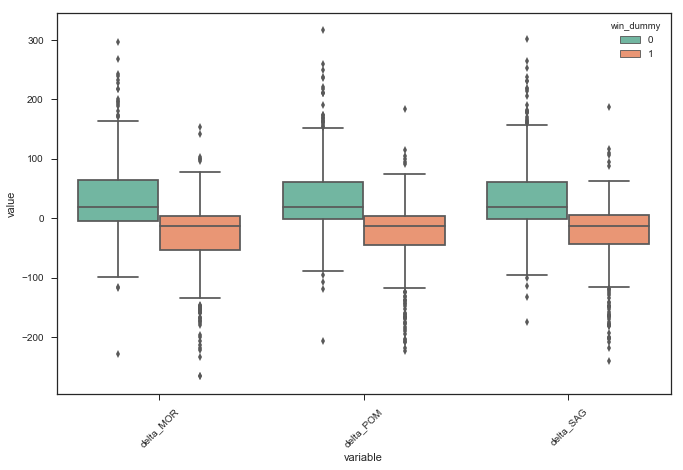

In [6]:
## > DATA VIZ TOURNEY 4
sns.set(style="ticks", color_codes=True)

df_tourn_cl_gr_4 = df_tourn_cl_gr.loc[:,['win_dummy',
                                         'delta_MOR', 'delta_POM', 'delta_SAG']]

fig, ax = plt.subplots(figsize=(11, 7))
sns.boxplot(x="variable", y="value", hue = 'win_dummy', ax=ax, 
            data=pd.melt(df_tourn_cl_gr_4, id_vars='win_dummy'), palette="Set2")
plt.xticks(rotation=45)

In [7]:
df_tourn_cl_gr = df_tourn_cl[(df_tourn_cl['Season'].isin(y_ok))].reindex()

df_tourn_cl_gr_ar = df_tourn_cl_gr.copy()

df_tourn_cl_gr_ar = df_tourn_cl_gr_ar.loc[:, ['win_dummy', 'delta_poss_m', 'delta_opp_poss_m',
                                       'delta_ass_ratio', 'delta_tov_ratio', 
                                       'delta_reb_rate',
                                       'delta_opp_true_fg_pct',
                                       'delta_off_rating_m', 'delta_def_rating_m',
                                       'delta_net_rating_m', 'delta_pace_m', 'delta_off_rating_m_last30D',
                                       'delta_def_rating_m_last30D', 'delta_net_rating_m_last30D',
                                       'delta_off_rating_m_vs_topseeds', 'delta_def_rating_m_vs_topseeds',
                                       'delta_net_rating_m_vs_topseeds', 'delta_c_N_season',
                                       'delta_seed_int',
                                       'delta_w_pct', 'delta_w_pct_last30D',
                                       'delta_w_pct_vs_topseeds', 'delta_c_N_champ_W',
                                       'delta_c_W_PCT_allT', 'delta_c_W_PCT_vs_topseeds_allT',
                                       'delta_MOR', 'delta_POM', 'delta_SAG']].fillna(0)

df_ar = pd.melt(df_tourn_cl_gr_ar, id_vars='win_dummy')

ar_out = df_ar.groupby(['variable']).apply(apply_somers).reset_index()

ar_out['AR'] = abs(ar_out['Dxy'])

ar_out.sort_values(by=['AR'], ascending=False)

,variable,Dxy,C,AR
22,delta_seed_int,-0.559574,0.220213,0.559574
7,delta_c_W_PCT_vs_topseeds_allT,0.477688,0.738844,0.477688
11,delta_net_rating_m,0.476172,0.738086,0.476172
13,delta_net_rating_m_vs_topseeds,0.468391,0.734195,0.468391
0,delta_MOR,-0.449195,0.275403,0.449195
2,delta_SAG,-0.443042,0.278479,0.443042
1,delta_POM,-0.442558,0.278721,0.442558
26,delta_w_pct_vs_topseeds,0.430195,0.715098,0.430195
16,delta_off_rating_m_vs_topseeds,0.393247,0.696623,0.393247
6,delta_c_W_PCT_allT,0.391122,0.695561,0.391122


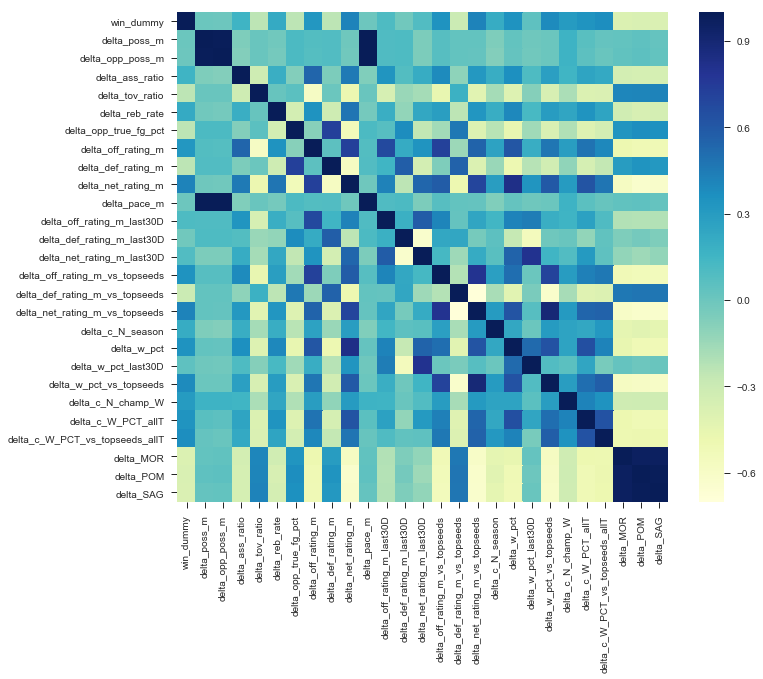

In [8]:
df_tourn_cl_gr_corr = df_tourn_cl_gr.copy()

df_tourn_cl_gr_corr = df_tourn_cl_gr_corr.loc[:, ['win_dummy', 'delta_poss_m', 'delta_opp_poss_m',
                                       'delta_ass_ratio', 'delta_tov_ratio', 
                                       'delta_reb_rate',
                                       'delta_opp_true_fg_pct',
                                       'delta_off_rating_m', 'delta_def_rating_m',
                                       'delta_net_rating_m', 'delta_pace_m', 'delta_off_rating_m_last30D',
                                       'delta_def_rating_m_last30D', 'delta_net_rating_m_last30D',
                                       'delta_off_rating_m_vs_topseeds', 'delta_def_rating_m_vs_topseeds',
                                       'delta_net_rating_m_vs_topseeds', 'delta_c_N_season',
                                       'delta_w_pct', 'delta_w_pct_last30D',
                                       'delta_w_pct_vs_topseeds', 'delta_c_N_champ_W',
                                       'delta_c_W_PCT_allT', 'delta_c_W_PCT_vs_topseeds_allT',
                                       'delta_MOR', 'delta_POM', 'delta_SAG']].fillna(0)

corr = df_tourn_cl_gr_corr.corr()
fig, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, cmap="YlGnBu", ax = ax)

In [10]:
## > SAVE
df_tourn_cl_gr.to_csv(path_datasets + '04Py_NCAA_dataset_con_indicatori.csv', sep = "|",
                      index=False)

In [11]:
df_agg_stats.head(10)

,Season,TeamID,TeamName,seed_int,seed_region,G,W,L,G_vs_topseeds,W_vs_topseeds,...,pace_m,off_rating_m_last30D,def_rating_m_last30D,net_rating_m_last30D,off_rating_m_vs_topseeds,def_rating_m_vs_topseeds,net_rating_m_vs_topseeds,w_pct,w_pct_last30D,w_pct_vs_topseeds
0,2003,1102,Air Force,74.506700,NoTour,28.0,12.0,16.0,8.0,1.0,...,61.976523,74.018258,86.412569,65.999960,64.853152,69.260034,67.730329,68.937291,65.363726,69.814116
1,2003,1103,Akron,74.506700,NoTour,27.0,13.0,14.0,2.0,1.0,...,77.378971,85.212635,80.135775,75.873388,89.149293,77.378971,80.563825,71.318064,75.994551,82.727895
2,2003,1104,Alabama,64.168288,Y,28.0,17.0,11.0,11.0,5.0,...,66.121877,80.241381,73.575292,76.779266,72.709667,63.784017,81.121864,77.642329,73.139277,80.728397
3,2003,1105,Alabama A&M,74.506700,NoTour,26.0,7.0,19.0,4.0,1.0,...,93.334976,70.709486,68.873013,73.869794,71.114093,79.420103,67.604937,64.673854,65.363726,74.468792
4,2003,1106,Alabama St,74.506700,NoTour,28.0,13.0,15.0,5.0,1.0,...,68.045133,63.138064,66.121877,67.292735,68.108326,71.249947,69.978450,70.810232,68.648729,72.461824
5,2003,1107,Albany NY,74.506700,NoTour,28.0,7.0,21.0,5.0,0.0,...,70.843874,69.195302,82.463046,65.032916,70.176512,87.894419,64.733569,63.990687,66.612007,65.575106
6,2003,1108,Alcorn St,74.506700,NoTour,33.0,14.0,19.0,4.0,0.0,...,86.412569,67.417400,65.635626,73.356451,69.715821,71.867780,70.843874,68.552929,76.737168,65.575106
7,2003,1110,American Univ,74.506700,NoTour,30.0,16.0,14.0,6.0,1.0,...,63.548506,84.029561,65.878282,86.635830,76.779266,69.846932,77.466311,73.795870,77.205585,71.114093
8,2003,1111,Appalachian St,74.506700,NoTour,26.0,16.0,10.0,3.0,1.0,...,99.954545,69.130663,79.620608,66.182927,77.820198,72.923703,76.528062,78.000000,70.209615,77.598154
9,2003,1112,Arizona,62.063096,Z,28.0,25.0,3.0,12.0,10.0,...,94.273004,89.908419,65.514642,90.802011,93.334976,63.607317,97.136502,97.136502,87.107980,95.469187
